In [16]:
import loadutil
import numpy as np
import matplotlib.pyplot as plt

def create_windows(data, window_size, overlap_size):
    step_size = window_size - overlap_size
    num_windows = (len(data) - overlap_size) // step_size
    windows = np.array([
        data[i * step_size: i * step_size + window_size]
        for i in range(num_windows)
    ])
    return windows

# Load data
filename = '10secPiLocal.bin' # target?
# filename = 'capture_par_0.1.bin' # target?
#filename = 'dab_plane30s.bin' # can be noisy
window_size = 500000  # 500k samples
overlap_fraction = 0.16  # 20% overlap-
overlap_size = int(window_size * overlap_fraction)

# Read the normalized complex data
data = loadutil.read_complex_byte(filename)

# # Plot a Small Amount of Raw IQ Data
# plt.figure()
# plt.plot(data[0:100].real)
# plt.title("Raw IQ Data")

# plt.show()


# Create the overlapping windows - based on overlap size
windows = create_windows(data, window_size, overlap_size)


nn = windows[0] #default set to first window
 

bs = 256  # batch size
overlap = 128  # corresponds to maximum timeshift - TRUNCATION
nbatches = int(np.floor((len(nn)-overlap)/bs))


# Now can process 'windows' which is an array of data windows
print("Number of windows:", len(windows))

Number of windows: 48


Truncated Range Doppler Data: [[1.02346008e+03 3.62163691e+02 7.71315649e+02 9.70282424e+02]
 [8.84087626e+02 3.25669329e+02 4.02765434e+02 6.59338713e+02]
 [4.54130323e+02 3.52878186e+02 3.58716972e+02 7.26680732e+02]
 [2.05832678e+03 7.26599986e+02 6.23987601e+02 1.18355531e+03]
 [3.60414734e+03 1.17362369e+03 8.18855978e+02 1.52553687e+03]
 [4.22454915e+03 1.43569560e+03 9.27398443e+02 1.58453749e+03]
 [3.56570199e+03 1.36725689e+03 9.39817318e+02 1.38317924e+03]
 [1.92805908e+03 9.62655574e+02 8.04804110e+02 1.05786726e+03]
 [6.73535239e+02 3.63006796e+02 5.29807962e+02 7.73109832e+02]
 [1.59362004e+03 2.99576341e+02 3.66672699e+02 5.84871034e+02]
 [1.75626583e+03 6.89709831e+02 5.94628812e+02 4.14034950e+02]
 [1.08681890e+03 7.80240090e+02 7.97175794e+02 3.40322990e+02]
 [1.16581621e+03 5.76225655e+02 7.85113554e+02 5.83747343e+02]
 [1.85755115e+03 2.59580559e+02 5.81369085e+02 8.85808897e+02]
 [1.73838736e+03 4.25044374e+02 3.50631563e+02 1.04170655e+03]
 [7.25943946e+02 7.437407

KeyboardInterrupt: 

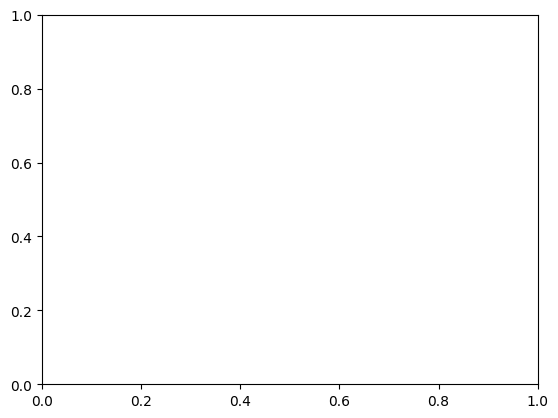

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy.signal as signal

# Other variables defined in the data import section ^^
N = window_size #500k samples
fs = 2048000 # Sampling rate - 2048MS/s
t = np.arange(N) / fs # Time vector

fig, ax = plt.subplots()  # Set up the plotting figure and axis
images = []  # List to store each image plot

# Process each window and create plot data
for i, nn in enumerate(windows[0:5]):

    ax.clear()

    fmap = np.arange(-(bs * 0.3), bs * 0.3, 1)
    rdmapX = np.zeros((len(fmap), len(nn)), dtype=complex)
    nn2F = np.conj(np.fft.fft(nn))

    for fi, f in enumerate(fmap):
        nnf = nn * np.exp(1j * 2 * np.pi * -f * t)
        rdmapX[fi, :] = np.fft.ifft(np.fft.fft(nnf) * nn2F)

    rdmapXTRUNC = np.abs(rdmapX[:, 1:overlap])
    print(f"Truncated Range Doppler Data: {rdmapXTRUNC[:, 1:5]}")
    
    ## DATA STUFFFF
    #Skip the zero range column - SHOW LOG10 of data np.log10
    image = ax.imshow(np.log10(rdmapXTRUNC), extent=[1, overlap, np.min(fmap), np.max(fmap)], aspect='auto')
    ax.set_xlabel('Range (samples)')
    ax.set_ylabel('Doppler (Hz)')
    ax.set_title(f"Window {i+1}")

    # Draw the figure to ensure it can be captured
    fig.canvas.draw()
    image_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    
    width, height = fig.canvas.get_width_height()  # Get the canvas size
    # print(f"Canvas size: {width}x{height}")  # Print canvas size
    print(f"Image Data Shape: {image_data.shape}")  # Check the shape before reshaping
    
    image_data = image_data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image_data)  # Append image data

# Set up animation
def animate_func(i):
    ax.clear()  # Clear everything on the axis
    ax.imshow(images[i], extent=[0, overlap, np.min(fmap), np.max(fmap)], aspect='auto')
    ax.axis('off')
    
    # ax.imshow(images[i], aspect='auto', interpolation='nearest')
    # ax.axis('off')

    return [ax]

ani = FuncAnimation(fig, animate_func, frames=len(images), interval=20)


ani.save('rdm_animation.gif', writer='pillow', fps=1)